In [1]:
%matplotlib inline


In [6]:
import matplotlib.pyplot as plt
import matplotlib
import os
from astropy.io import ascii, fits
import glob
from scipy.ndimage import gaussian_filter1d
from astropy.time import Time
import glob
import re
from astropy.table import Table
import astropy.table as at
import astropy
import numpy as np
import extinction

In [4]:
matplotlib.rcParams['figure.figsize']      = [15, 5]
matplotlib.rcParams['image.origin']        = 'lower'
matplotlib.rcParams['image.interpolation'] = 'none'
matplotlib.rcParams['image.cmap']          = 'inferno'
matplotlib.rcParams['image.aspect']        = 'auto'

In [7]:

spec_log = Table(names = ['phase', 'name', 'file'], dtype = ['i4', 'U8', 'U64'])
for folder in glob.glob('./reduced_spectra/*'):
    objname = folder.split('/')[2]
    f_list = glob.glob(folder+'/*')
#    obj_dict = {}
    for df in f_list:
        t = int(re.findall(r'd\d+', df)[0][1:])
#        obj_dict[t] = df
        spec_log.add_row([t, objname, df])
#    f_dict[objname] = obj_dict
spec_log.sort('phase')

z_dict = {'2010jl':0.0107,
          '2005ip':0.0072,
          '2020aekp':0.046,
          '2020nxt':0.023,
          '1998S':0.003, 
          '2011fe':0.0008,
          '2015G': 0.0045,
          '2021csp':0.083,
          '2017egm':0.030721,
          '2020fqv':0.007522}

type_dict = {'2010jl':'IIn',
          '2005ip':'IIn',
          '2020aekp':'Ia-CSM',
          '2020nxt':'Ibn',
          '1998S':'IIn', 
          '2011fe':'Ia',
          '2015G': 'Ibn',
          '2021csp':'Icn',
          '2017egm':'SLSN-I',
          '2020fqv':'Ia'}

In [ ]:
xcoords=[1238,1484  ,1548  ,1640  ,1660    ,1746   ,1907   ,2139   ,2323   ,2650           , 2795  ]
#xcoords=np.asarray(xcoords)*1.e-4
names=['N V' ,'N IV','C IV','He II','O III','N III','C III','N II]','C II]','Mg II + Fe II','Mg II']


In [16]:
from numpy import polyfit, poly1d
from scipy.integrate import simps
def calc_emflux(wav, flux, wav_up, wav_low):
    ind = (wav>wav_low)&(wav<wav_up)
    x = np.arange(len(wav))
    up_ind = max(x[ind])
    low_ind = min(x[ind])
    p = polyfit(np.array([wav[low_ind-1],wav[low_ind],wav[low_ind+1],wav[up_ind-1],wav[up_ind],wav[up_ind+1]]), 
               np.array([flux[low_ind-1],flux[low_ind],flux[low_ind+1],flux[up_ind-1],flux[up_ind],flux[up_ind+1]]),
               deg = 1)
    continuum = poly1d(p)
    emflux = simps(flux[ind]-continuum(wav[ind]), wav[ind])
    return emflux

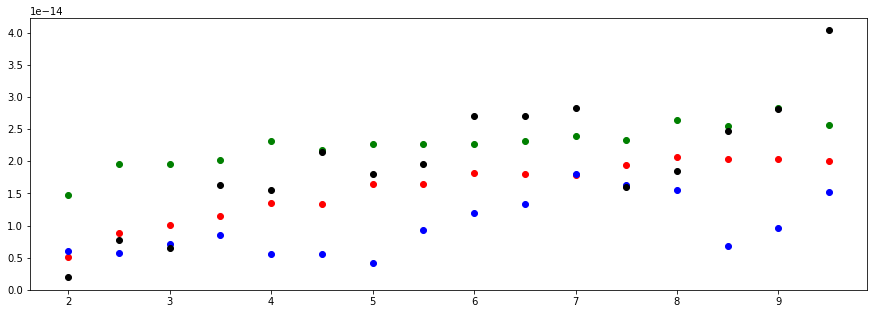

In [21]:
spec = fits.open('./reduced_spectra/2005ip/2005ip_d3042FUV_x1d.fits')
z = z_dict['2005ip']
ebv = 0.047
a_v = 3.1*ebv

for bound in np.arange(2., 10., 0.5):
    wav = spec[1].data['WAVELENGTH'][0]/(1+z)
    flux = spec[1].data['FLUX'][0]
    wav_up = 1242.8+bound
    wav_low = 1238.8-bound
    extinc = extinction.fitzpatrick99(np.array([wav_up,wav_low]), a_v, 3.1)[0]
    emflux = calc_emflux(wav, flux, wav_up, wav_low)*10**(extinc/2.5)
    plt.scatter(bound, emflux,color ='r')
    
for bound in np.arange(2., 10., 0.5):
    wav = spec[1].data['WAVELENGTH'][0]/(1+z)
    flux = spec[1].data['FLUX'][0]
    wav_up =  1486.5+bound
    wav_low = 1483.3-bound
    extinc = extinction.fitzpatrick99(np.array([wav_up,wav_low]), a_v, 3.1)[0]
    emflux = calc_emflux(wav, flux, wav_up, wav_low)*10**(extinc/2.5)*4.8/2.72
    plt.scatter(bound, emflux,color ='g')
    
for bound in np.arange(2., 10., 0.5):
    wav = spec[1].data['WAVELENGTH'][0]/(1+z)
    flux = spec[1].data['FLUX'][0]
    wav_up =  1550.7+bound
    wav_low = 1548.2-bound
    extinc = extinction.fitzpatrick99(np.array([wav_up,wav_low]), a_v, 3.1)[0]
    emflux = calc_emflux(wav, flux, wav_up, wav_low)*10**(extinc/2.5)*4.8/1.14
    plt.scatter(bound, emflux,color ='b')
    
for bound in np.arange(2., 10., 0.5):
    wav = spec[1].data['WAVELENGTH'][0]/(1+z)
    flux = spec[1].data['FLUX'][0]
    wav_up = 1640.4+bound
    wav_low = 1640.4-bound
    extinc = extinction.fitzpatrick99(np.array([wav_up,wav_low]), a_v, 3.1)[0]
    emflux = calc_emflux(wav, flux, wav_up, wav_low)*10**(extinc/2.5)*4.8/0.88
    plt.scatter(bound, emflux,color ='k')

In [32]:
def plot_region(ax, wav, flux, linewaves, linename = None, bound = 6, xlim =5, ylim = 5e-15):
    
    wav_up =  max(linewaves)+bound
    wav_low = min(linewaves)-bound
    ind = (wav>wav_low)&(wav<wav_up)
    x = np.arange(len(wav))
    up_ind = max(x[ind])
    low_ind = min(x[ind])
    p = polyfit(np.array([wav[low_ind-1],wav[low_ind],wav[low_ind+1],wav[up_ind-1],wav[up_ind],wav[up_ind+1]]), 
                   np.array([flux[low_ind-1],flux[low_ind],flux[low_ind+1],flux[up_ind-1],flux[up_ind],flux[up_ind+1]]),
                   deg = 1)
    continuum = poly1d(p)
    x = np.arange(wav_low-1, wav_up+1)
    ax.text(wav_up, ylim/5*4,linename)
    ax.plot(x,continuum(x))
    ax.scatter(wav, flux, marker = 'o')
    ax.set_xlim(wav_low-xlim, wav_up+xlim)
    ax.set_ylim(-ylim/10, ylim)

(-5e-16, 5e-15)

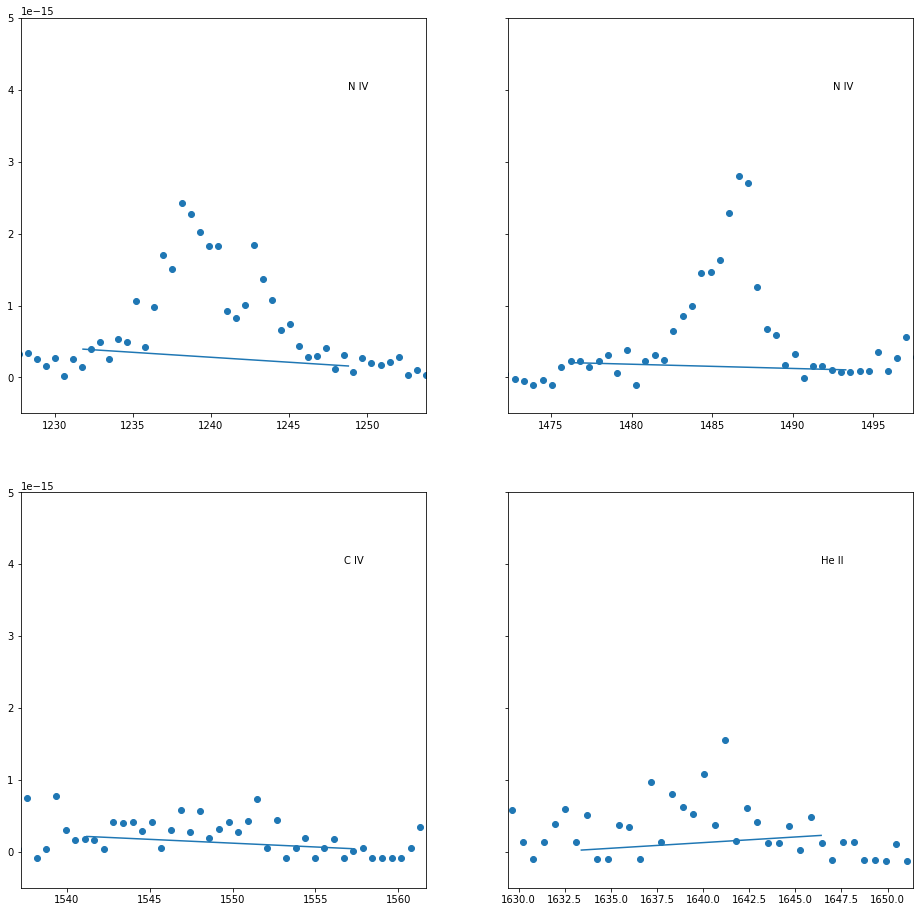

In [33]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (16, 16), sharey = True)



wav = spec[1].data['WAVELENGTH'][0]/(1+z)
flux = spec[1].data['FLUX'][0]
bound = 6

plot_region(axes[0,0], wav, flux, [1238.8, 1242.8], linename = 'N IV', bound = bound, xlim =5, ylim = 5e-15)

wav_up =  1486.5+bound
wav_low = 1483.3-bound
ind = (wav>wav_low)&(wav<wav_up)
x = np.arange(len(wav))
up_ind = max(x[ind])
low_ind = min(x[ind])
p = polyfit(np.array([wav[low_ind-1],wav[low_ind],wav[low_ind+1],wav[up_ind-1],wav[up_ind],wav[up_ind+1]]), 
               np.array([flux[low_ind-1],flux[low_ind],flux[low_ind+1],flux[up_ind-1],flux[up_ind],flux[up_ind+1]]),
               deg = 1)
continuum = poly1d(p)
x = np.arange(wav_low-1, wav_up+1)
axes[0,1].text(wav_up, 4e-15, 'N IV')
axes[0,1].plot(x,continuum(x))
axes[0,1].scatter(wav, flux, marker = 'o')
axes[0,1].set_xlim(wav_low-5, wav_up+5)
axes[0,1].set_ylim(-5e-16, 5e-15)

wav_up =  1550.7+bound
wav_low = 1548.2-bound
ind = (wav>wav_low)&(wav<wav_up)
x = np.arange(len(wav))
up_ind = max(x[ind])
low_ind = min(x[ind])
p = polyfit(np.array([wav[low_ind-1],wav[low_ind],wav[low_ind+1],wav[up_ind-1],wav[up_ind],wav[up_ind+1]]), 
               np.array([flux[low_ind-1],flux[low_ind],flux[low_ind+1],flux[up_ind-1],flux[up_ind],flux[up_ind+1]]),
               deg = 1)
continuum = poly1d(p)
x = np.arange(wav_low-1, wav_up+1)
axes[1,0].text(wav_up, 4e-15, 'C IV')
axes[1,0].plot(x,continuum(x))
axes[1,0].scatter(wav, flux, marker = 'o')
axes[1,0].set_xlim(wav_low-5, wav_up+5)
axes[1,0].set_ylim(-5e-16, 5e-15)

wav_up = 1640.4+bound
wav_low = 1640.4-bound
ind = (wav>wav_low)&(wav<wav_up)
x = np.arange(len(wav))
up_ind = max(x[ind])
low_ind = min(x[ind])
p = polyfit(np.array([wav[low_ind-1],wav[low_ind],wav[low_ind+1],wav[up_ind-1],wav[up_ind],wav[up_ind+1]]), 
               np.array([flux[low_ind-1],flux[low_ind],flux[low_ind+1],flux[up_ind-1],flux[up_ind],flux[up_ind+1]]),
               deg = 1)
continuum = poly1d(p)
x = np.arange(wav_low-1, wav_up+1)
axes[1,1].text(wav_up, 4e-15, 'He II')
axes[1,1].plot(x,continuum(x))
axes[1,1].scatter(wav, flux, marker = 'o')
axes[1,1].set_xlim(wav_low-5, wav_up+5)
axes[1,1].set_ylim(-5e-16, 5e-15)


